In [1]:
# load libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(AnnotationHub)
library(stringr)
library(ggplot2)
library(ggpubr)
library(ggVolcano)
library(viridis)
library(ggradar)
library(dplyr)
library(scales)
library(tibble)
library(patchwork)
})
set.seed(123)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


In [2]:
# load peaks and meta data
counts <- Read10X_h5(filename = "./matrix/filtered_peak_bc_matrix.h5")
metadata <- read.csv("./meta/singlecell.csv", header = TRUE, row.names = 1)

In [3]:
# load chrom assay
chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'mm10',
  fragments = './matrix/fragments.tsv.gz',
  min.cells = 1
)

Computing hash



In [4]:
# create seurat object
sample <- CreateSeuratObject(
    counts = chrom_assay,
    assay = "peaks",
    project = "ATAC",
    meta.data = metadata
)
sample

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
“Some cells in meta.data not present in provided counts matrix.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_”


An object of class Seurat 
145053 features across 1876 samples within 1 assay 
Active assay: peaks (145053 features, 0 variable features)

In [5]:
# create an annotationhub instance
# ah <- AnnotationHub()

# Download the database we want to use
# MouseEnsDb <- query(ah, c("EnsDb", "Mus musculus", "98"))[[1]]

# extract gene annotations from EnsDb
# suppressWarnings(annotations <- GetGRangesFromEnsDb(ensdb = MouseEnsDb))

# change to UCSC style
# seqlevelsStyle(annotations) <- 'UCSC'
# save the annotations file
# saveRDS(annotations, file = "EnsDb.Mmusculus.v98.annotations.ucsc.rds")

# load the annotations file
annotations <- readRDS("meta/EnsDb.Mmusculus.v98.annotations.ucsc.rds")

In [6]:
# add the gene information to the object
Annotation(sample) <- annotations

In [7]:
# compute nucleosome signal score per cell
sample <- NucleosomeSignal(object = sample)

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



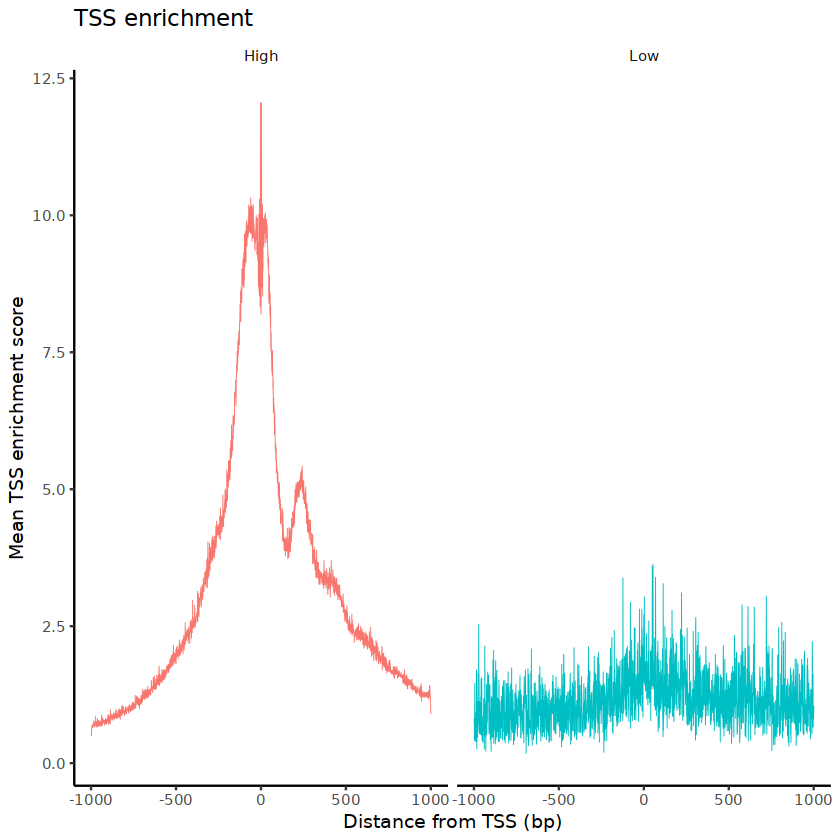

In [8]:
# compute TSS enrichment score per cell
sample <- TSSEnrichment(object = sample, fast = FALSE, assay = "peaks")

sample$high.tss <- ifelse(sample$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(sample, group.by = 'high.tss', assay = "peaks") + NoLegend()

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of blacklist_ratio.”


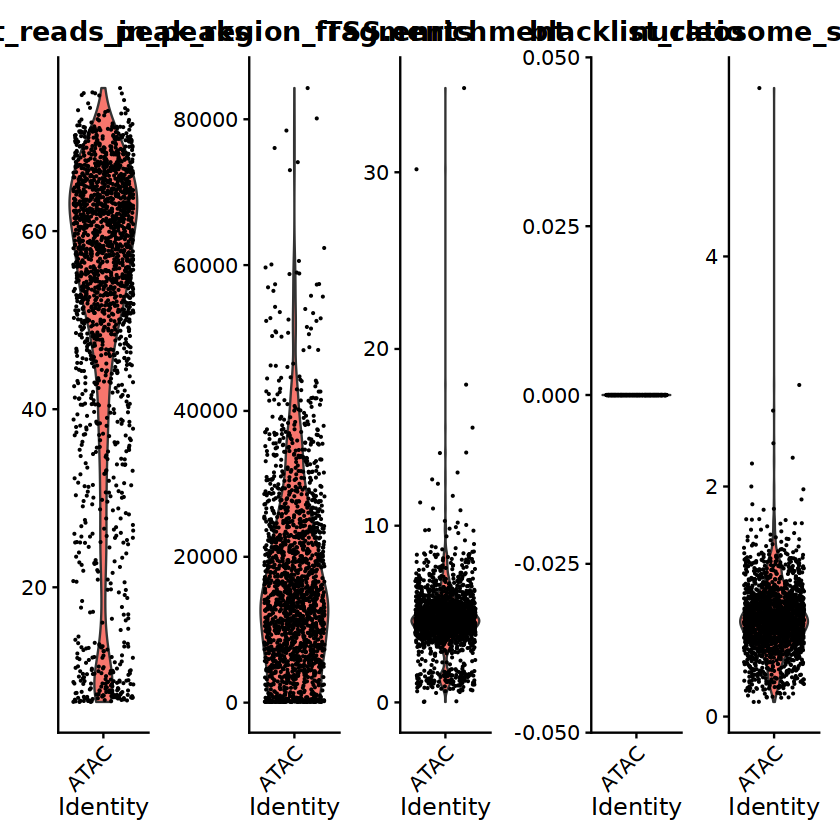

In [9]:
# add blacklist ratio and fraction of reads in peaks
sample$pct_reads_in_peaks <- sample$peak_region_fragments / sample$passed_filters * 100
sample$blacklist_ratio <- sample$blacklist_region_fragments / sample$peak_region_fragments
sample$nucleosome_group <- ifelse(sample$nucleosome_signal > 4, 'NS > 4', 'NS < 4')

VlnPlot(sample, features = c('pct_reads_in_peaks', 'peak_region_fragments', 'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'), pt.size = 0.1, ncol = 5)

In [10]:
# save the raw sample
# sample_raw <- sample
# saveRDS(sample_raw, file = "sample_mouse_ATAC_raw.rds")
sample_raw <- readRDS("sample_mouse_ATAC_raw.rds")

In [11]:
# remove cells that are outliers for these QC metrics
sample <- subset(
  x = sample_raw,
  subset = peak_region_fragments > 3000 &
    peak_region_fragments < 20000 &
    pct_reads_in_peaks > 15 &
    blacklist_ratio < 0.05 &
    nucleosome_signal < 4 &
    TSS.enrichment > 2
)
sample

An object of class Seurat 
145053 features across 1023 samples within 1 assay 
Active assay: peaks (145053 features, 0 variable features)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
“Some features contain 0 total counts”
Running SVD

Scaling cell embeddings



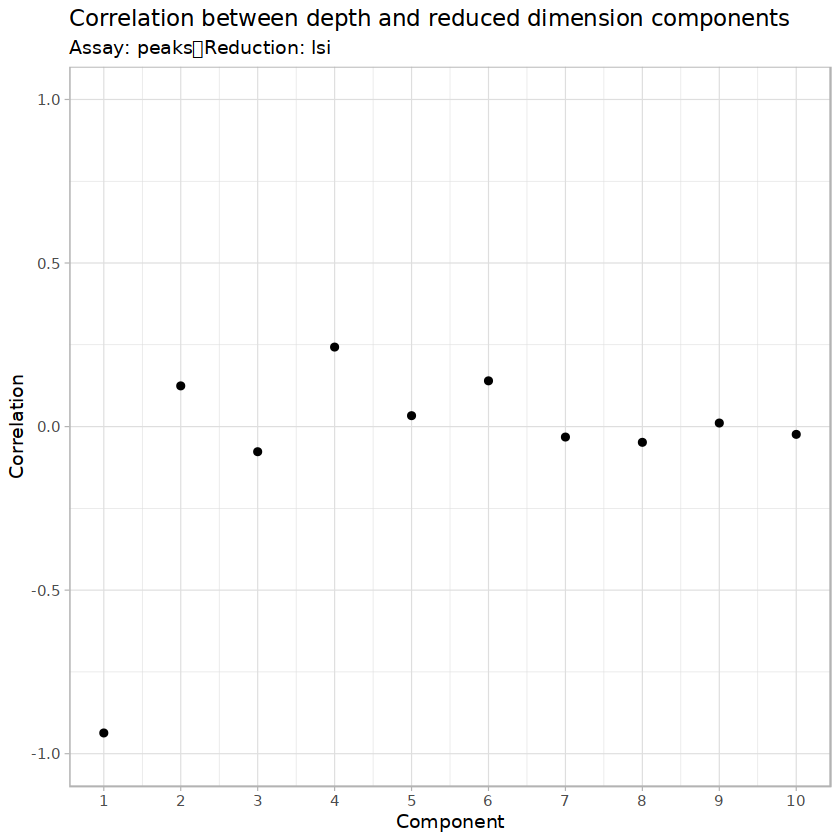

In [12]:
# normalization and linear dimensional reduction
sample <- RunTFIDF(sample)
sample <- FindTopFeatures(sample, min.cutoff = 'q0')
sample <- RunSVD(sample)

DepthCor(sample)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Computing nearest neighbor graph

Computing SNN



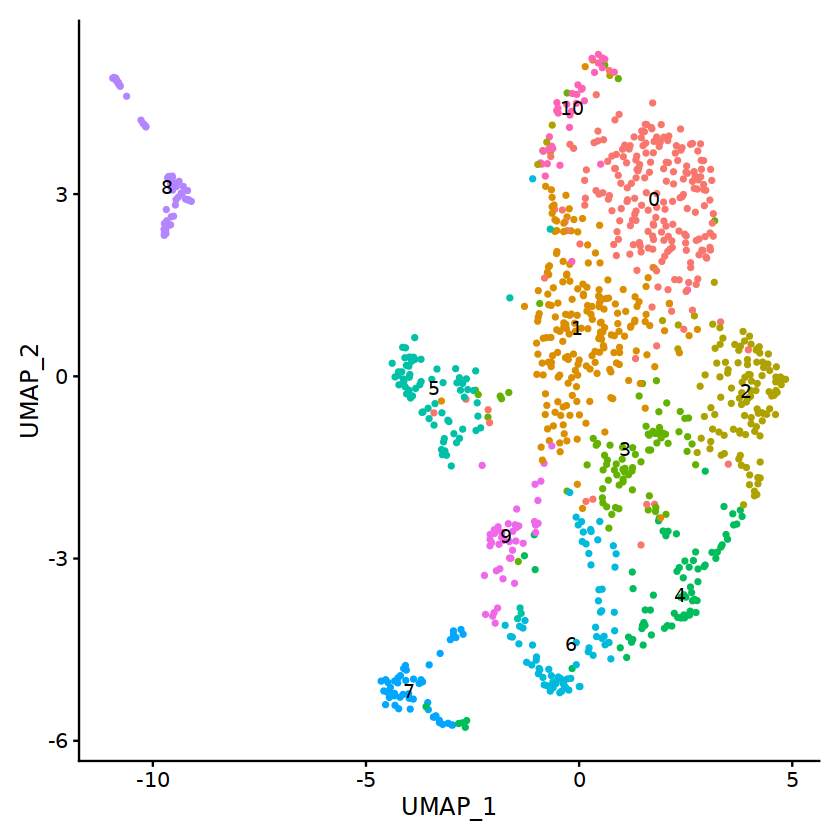

In [13]:
# dimension reduction and clustering
sample <- RunUMAP(object = sample, reduction = 'lsi', dims = 2:30, verbose = F)
sample <- FindNeighbors(object = sample, reduction = 'lsi', dims = 2:30)
sample <- FindClusters(object = sample, verbose = FALSE, algorithm = 3, resolution = 1)
DimPlot(object = sample, label = TRUE) + NoLegend()

In [14]:
# remove isolated cell clusters
sample <- subset(sample, idents = c(5, 8), invert = T)
sample

An object of class Seurat 
145053 features across 900 samples within 1 assay 
Active assay: peaks (145053 features, 145053 variable features)
 2 dimensional reductions calculated: lsi, umap

Computing nearest neighbor graph

Computing SNN



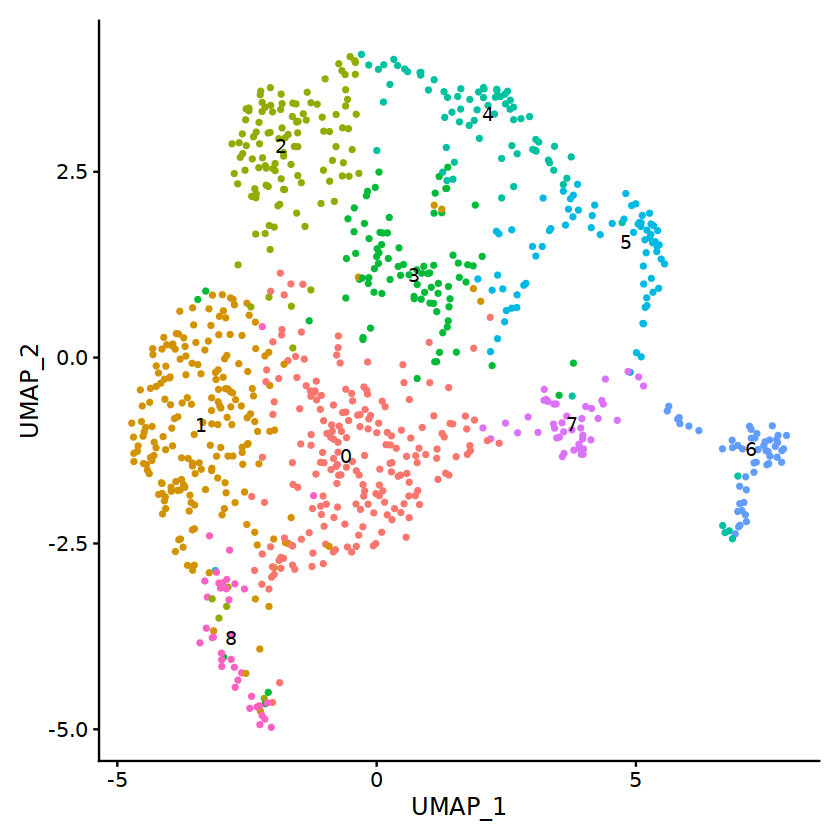

In [15]:
# dimension reduction and clustering
sample <- RunUMAP(object = sample, reduction = 'lsi', dims = 2:30, verbose = F)
sample <- FindNeighbors(object = sample, reduction = 'lsi', dims = 2:30)
sample <- FindClusters(object = sample, verbose = FALSE, algorithm = 3, resolution = 1)
DimPlot(object = sample, label = TRUE) + NoLegend()

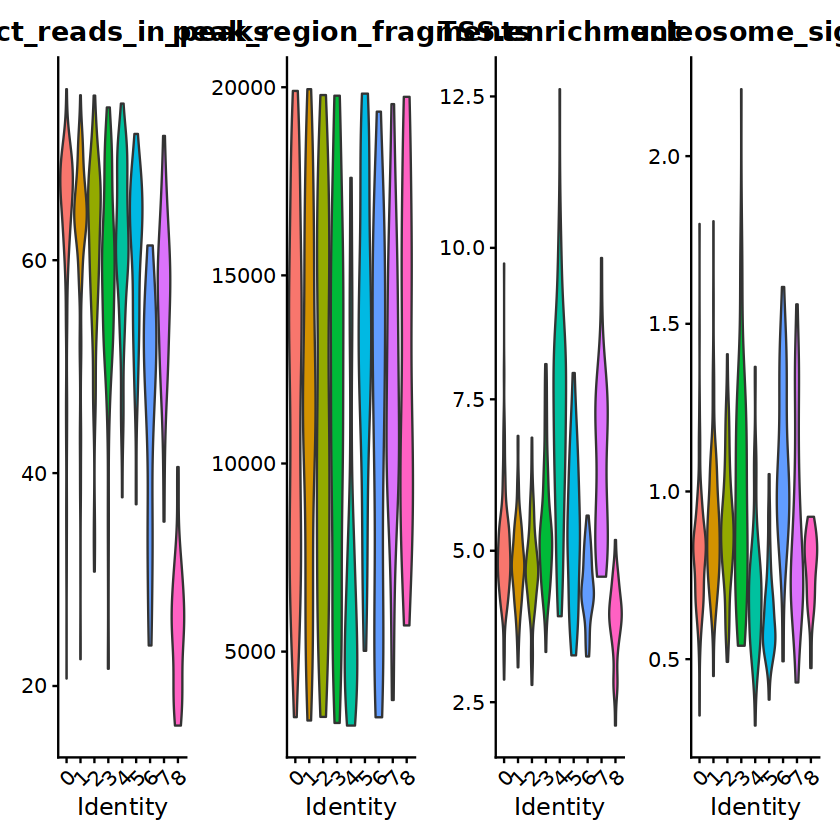

In [16]:
# quality control by cluster
VlnPlot(sample, features = c('pct_reads_in_peaks', 'peak_region_fragments', 'TSS.enrichment', 'nucleosome_signal'), group.by = "seurat_clusters", pt.size = 0, ncol = 4)
ggsave("figure/quality_control_scatac_mouse_raw.pdf", width = 10, height = 4)

In [17]:
# remove low quality cell cluster
sample <- subset(sample, idents = c(8), invert = T)
sample

An object of class Seurat 
145053 features across 863 samples within 1 assay 
Active assay: peaks (145053 features, 145053 variable features)
 2 dimensional reductions calculated: lsi, umap

Computing nearest neighbor graph

Computing SNN



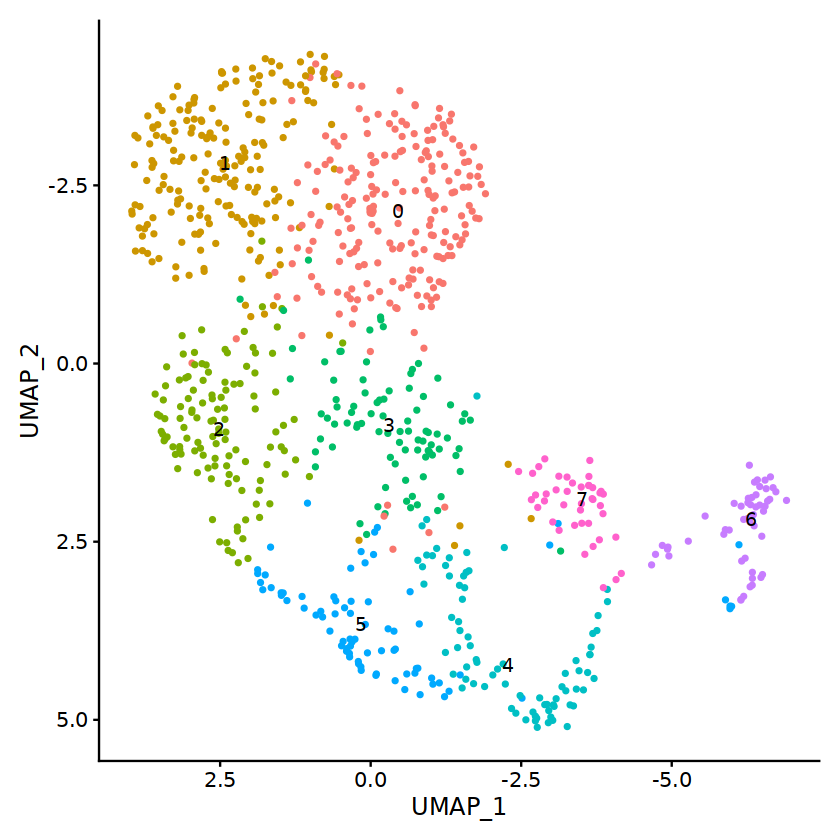

In [18]:
# dimension reduction and clustering
sample <- RunUMAP(object = sample, reduction = 'lsi', dims = 2:31, verbose = F)
sample <- FindNeighbors(object = sample, reduction = 'lsi', dims = 2:31)
sample <- FindClusters(object = sample, verbose = FALSE, algorithm = 3, resolution = 1)
DimPlot(object = sample, label = TRUE) + scale_x_reverse() + scale_y_reverse() + NoLegend()

In [19]:
# compute gene activities
gene.activities <- GeneActivity(sample)

Extracting gene coordinates

Extracting reads overlapping genomic regions



In [20]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
sample[['RNA']] <- CreateAssayObject(counts = gene.activities)
sample <- NormalizeData(
  object = sample,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(sample$nCount_RNA)
)

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


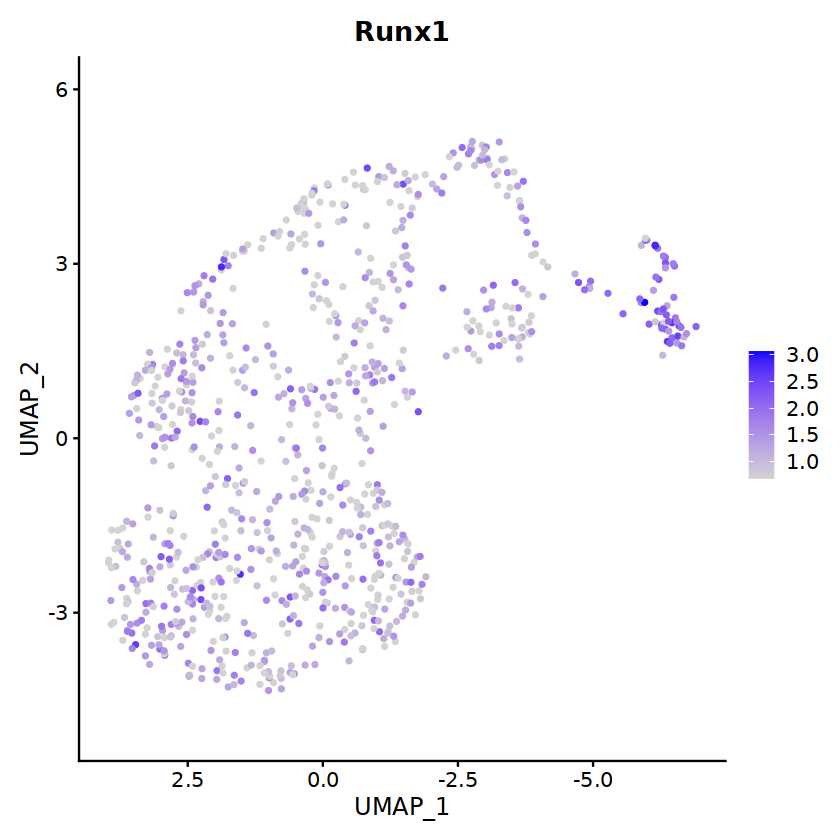

In [21]:
# marker gene activity
DefaultAssay(sample) <- 'RNA'
FeaturePlot(object = sample, features = c('Runx1'), min.cutoff = 'q10') + scale_x_reverse()

In [22]:
# Load the pre-processed scRNA-seq data
sample_rna <- readRDS("../1_EHT_RNA_Preprocessing/sample_mouse_annotated.rds")
sample_rna <- FindVariableFeatures(object = sample_rna, nfeatures = 5000)

In [23]:
# transfer anchors
transfer.anchors <- FindTransferAnchors(reference = sample_rna, query = sample, reference.assay = 'RNA', reduction = 'cca', dims = 1:40)

Warning message:
“npcs is smaller than the largest value requested by the dims parameter.
Setting npcs to 40 and continuing.”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4235 anchors

Filtering anchors

	Retained 1669 anchors



In [24]:
# predict labels
predicted.labels <- TransferData(anchorset = transfer.anchors, refdata = sample_rna$celltype, weight.reduction = sample[['lsi']], dims = 2:30)
sample <- AddMetaData(object = sample, metadata = predicted.labels)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



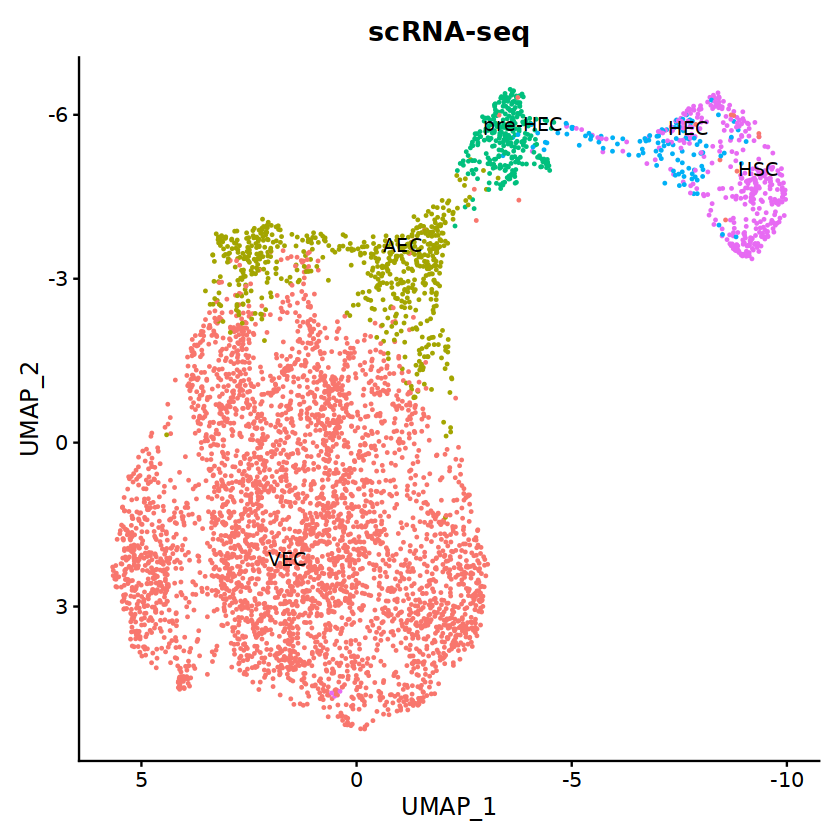

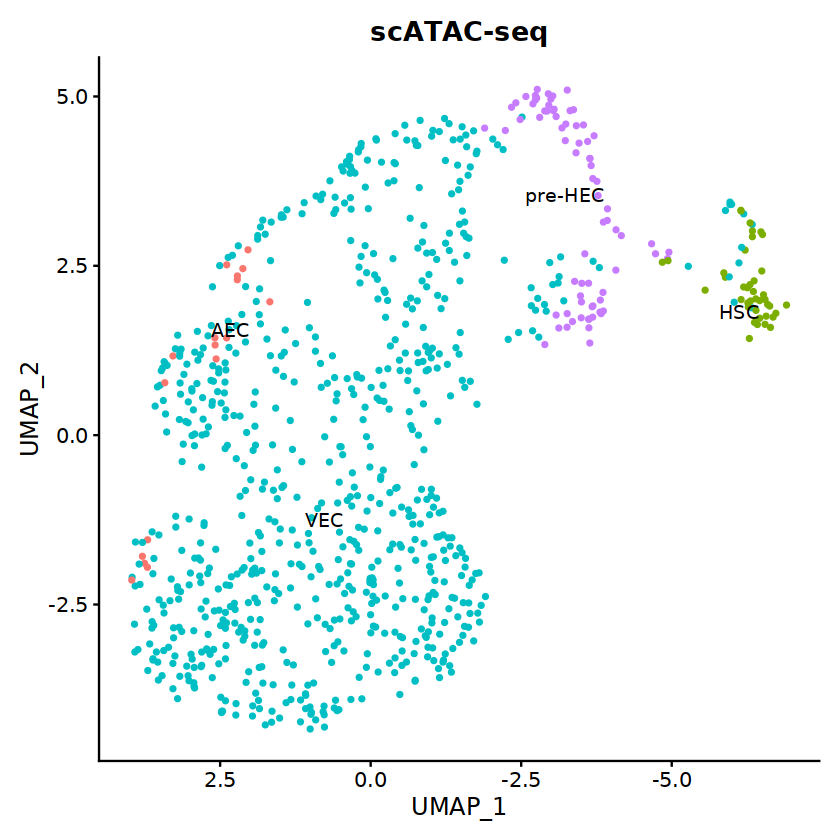

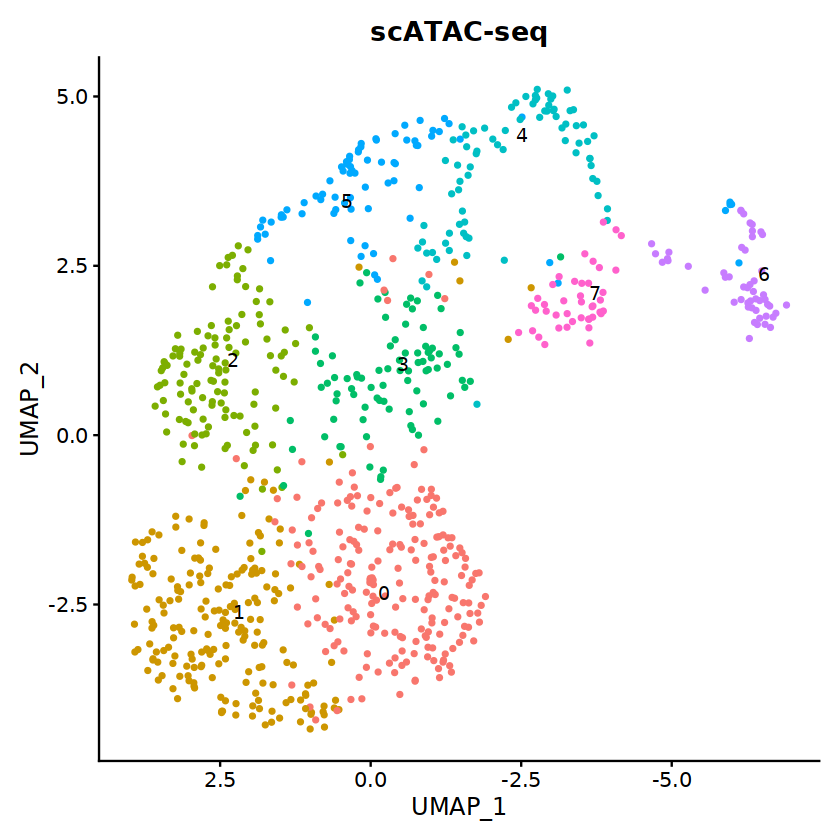

In [25]:
# celltype umap
DimPlot(sample_rna, group.by = 'celltype', label = TRUE, repel = TRUE) + scale_x_reverse() + scale_y_reverse() + NoLegend() + ggtitle('scRNA-seq')
DimPlot(sample, group.by = 'predicted.id', label = TRUE, repel = TRUE) + scale_x_reverse() + NoLegend() + ggtitle('scATAC-seq')
DimPlot(sample, group.by = 'ident', label = TRUE, repel = TRUE) + scale_x_reverse() + NoLegend() + ggtitle('scATAC-seq')

In [26]:
# save the transfered sample
sample_transfered <- sample
# saveRDS(sample_transfered, file = "sample_mouse_ATAC_transfered.rds")
# sample_transfered <- readRDS("sample_mouse_ATAC_transfered.rds")

In [27]:
# remove strange VEC in cluster 7
sample <- subset(sample_transfered, cells = rownames(sample@meta.data[sample@meta.data$predicted.id %in% c("VEC") & sample@meta.data$seurat_clusters == 7, ]), invert = T)
sample

An object of class Seurat 
166658 features across 850 samples within 2 assays 
Active assay: RNA (21605 features, 0 variable features)
 1 other assay present: peaks
 2 dimensional reductions calculated: lsi, umap

Computing nearest neighbor graph

Computing SNN



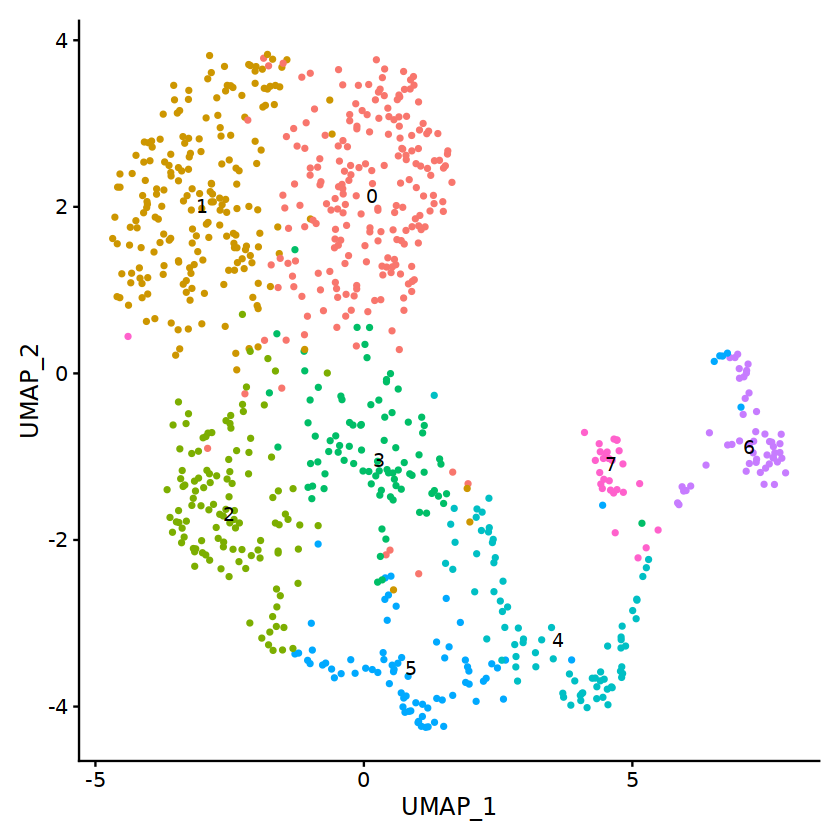

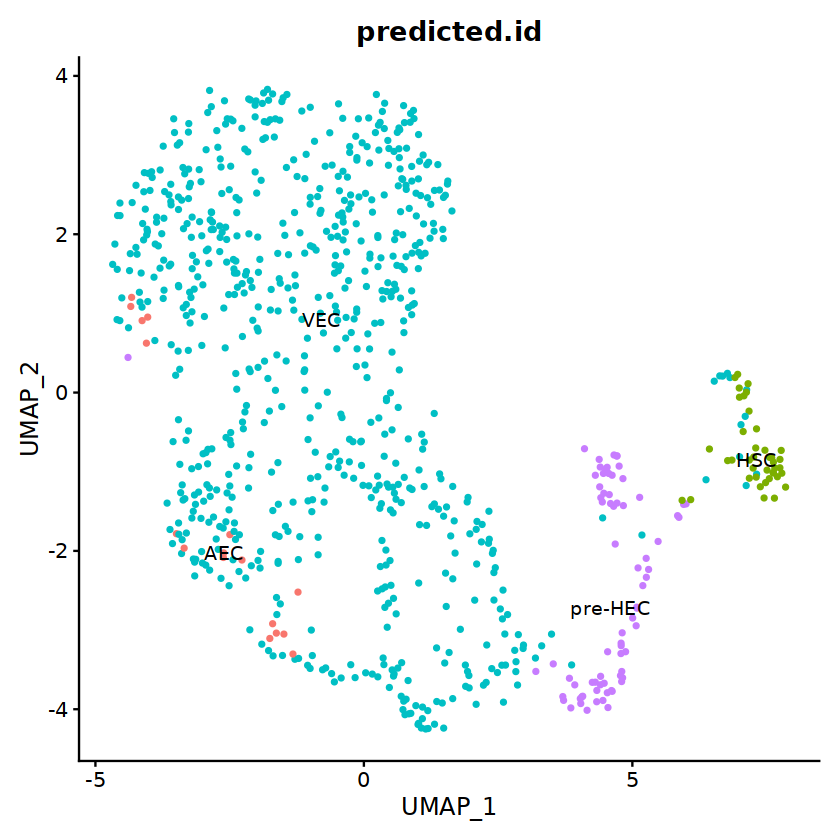

In [28]:
# dimension reduction and clustering
sample <- RunUMAP(object = sample, reduction = 'lsi', dims = 2:31, verbose = F)
sample <- FindNeighbors(object = sample, reduction = 'lsi', dims = 2:31)
DimPlot(object = sample, label = TRUE) + NoLegend()
DimPlot(object = sample, label = TRUE, group.by = "predicted.id") + NoLegend()

In [29]:
# replace each label with its most likely prediction
# for(i in levels(sample)) {
#   cells_to_reid <- WhichCells(sample, idents = i)
#   newid <- names(sort(table(sample$predicted.id[cells_to_reid]),decreasing=TRUE))[1]
#   Idents(sample, cells = cells_to_reid) <- newid
# }
# DimPlot(sample, label = TRUE, repel = TRUE) + NoLegend() + ggtitle('scATAC-seq')

In [30]:
# save the annotated sample
# sample_annotated <- sample
# saveRDS(sample_annotated, file = "sample_mouse_ATAC_annotated.rds")

In [31]:
# marker gene activity Cdh5, Lyve1, Aplnr, Dll4, Gja4, Gja5, Runx1
DefaultAssay(sample) <- 'RNA'
gene_plot <- c("Cdh5", "Lyve1", "Aplnr", "Hey1", "Dll4", "Gja4", "Gja5", "Runx1", "Ptprc")
for (gene in gene_plot) {
    FeaturePlot(object = sample, features = gene, min.cutoff = "q10", cols = c("grey90","red3"), pt.size = 0.5)
    ggsave(paste("figure/EHT_scATAC", gene, "mouse.pdf", sep = "_"), width = 6, height = 5)
}

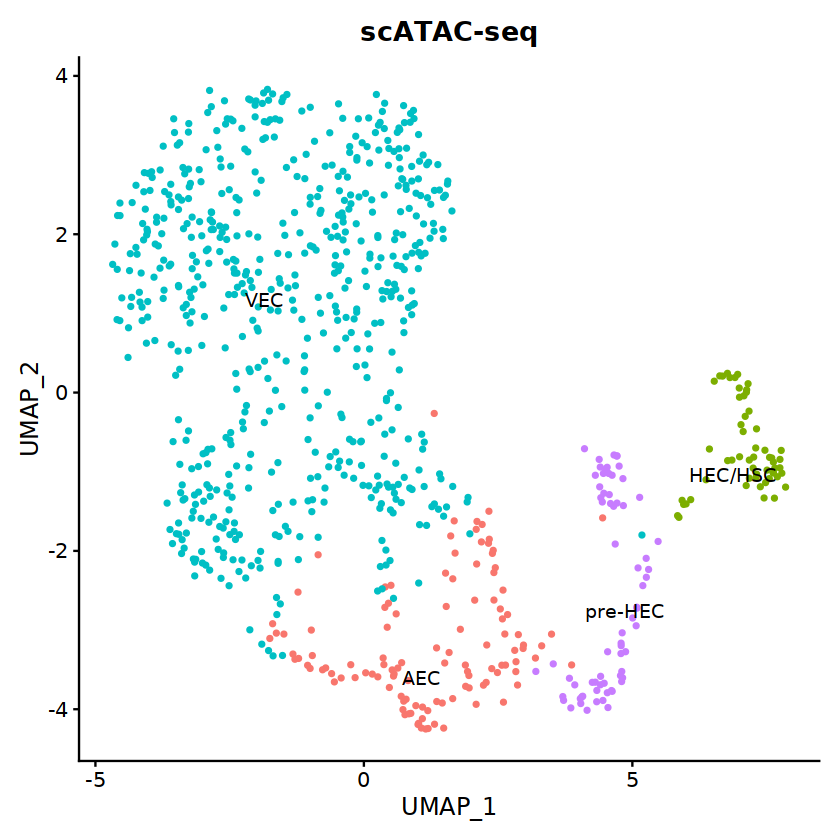

In [32]:
# refine the celltype for atac sample
sample$celltype <- as.character(sample$predicted.id)
# sample$celltype[sample$celltype == "VEC"] <- "EC"
# sample$celltype[sample$celltype == "AEC"] <- "EC"
# sample$celltype[sample$celltype == "HSC"] <- "HEC/HSC"
# sample$celltype[sample$seurat_clusters == 6] <- "HEC/HSC"
sample@meta.data[names(which(sample@reductions$umap@cell.embeddings[, "UMAP_1"] < -2)), "celltype"] <- "VEC"
sample$celltype[sample$seurat_clusters == 5] <- "AEC"
sample$celltype[sample$seurat_clusters == 4 & sample$predicted.id == "VEC"] <- "AEC"
sample$celltype[sample$seurat_clusters == 6] <- "HEC/HSC"
hsc_corrected <- intersect(rownames(subset(sample@meta.data, seurat_clusters == 5)), names(which(sample@reductions$umap@cell.embeddings[, "UMAP_1"] > 5)))
sample@meta.data[hsc_corrected, "celltype"] <- "HEC/HSC"
DimPlot(sample, group.by = 'celltype', label = TRUE, repel = TRUE) + NoLegend() + ggtitle('scATAC-seq')

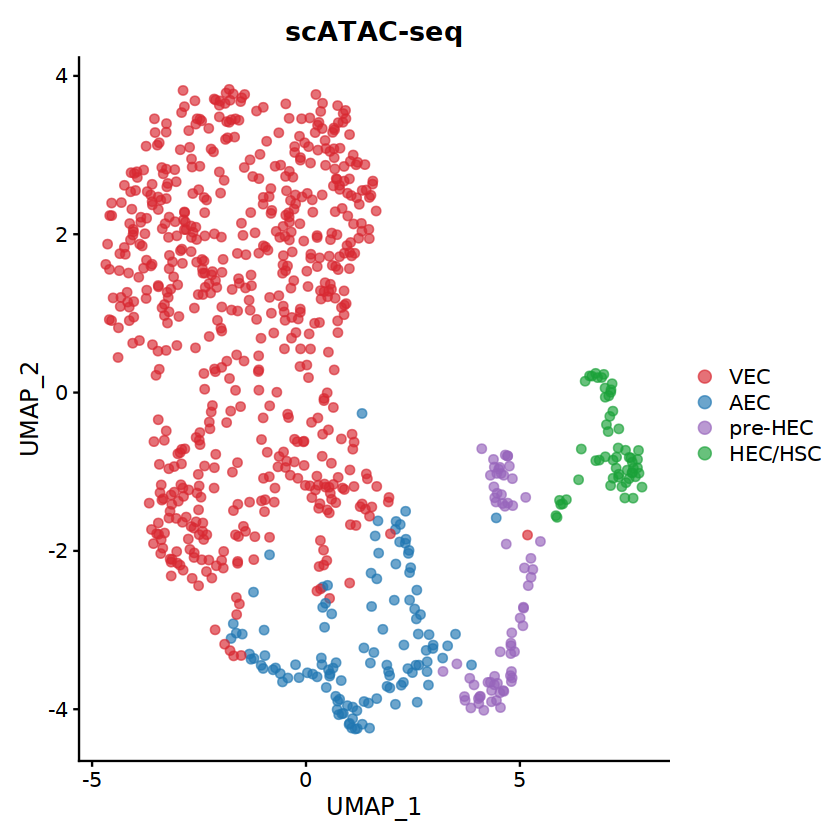

In [33]:
# draw and save the umap
sample$celltype <- as.character(sample$celltype)
sample$celltype <- factor(sample$celltype, levels = c("VEC","AEC","pre-HEC","HEC/HSC"))
DimPlot(sample, group.by = 'celltype', repel = TRUE, cols = alpha(c("#D82831", "#2077B2", "#9765BA", "#1BA138"), 0.66), pt.size = 2) + ggtitle('scATAC-seq')
ggsave("figure/umap_scatac_eht_mouse.pdf", width = 6.5, height = 5)

Warning message:
“Scaling data with a low number of groups may produce misleading results”


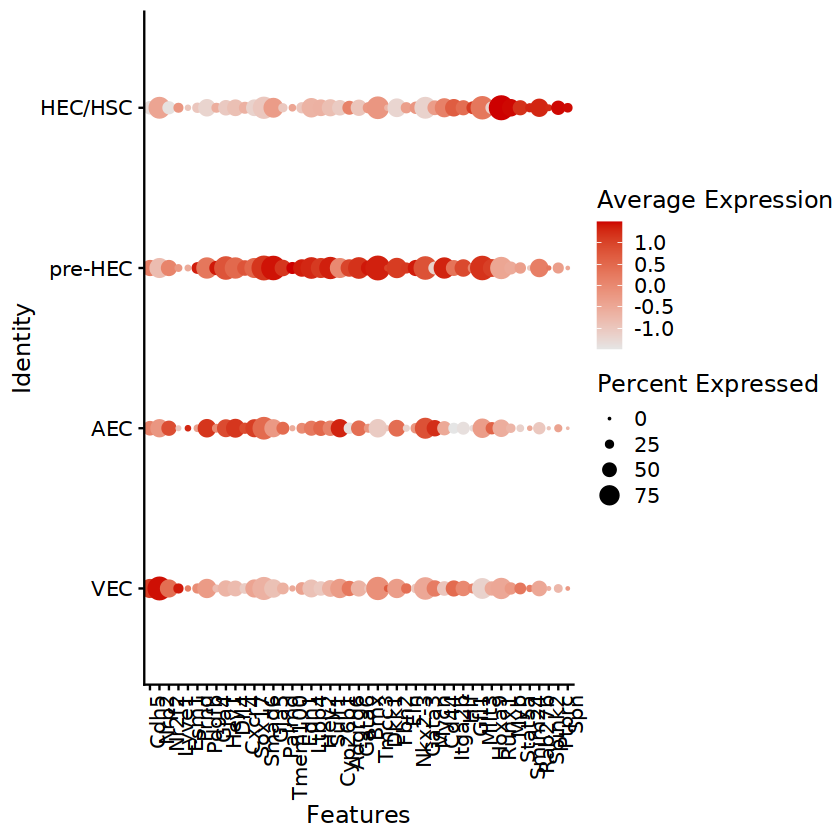

In [34]:
# all EHT markers activities
EHT_scorecard <- c("CDH5","NRP2","NR2F2","Lyve1",
                 "ESM1","PRND","PDGFB",
                 "GJA4","HEY1","DLL4","CXCR4","SOX17","SMAD6","GJA5",
                 "PALMD","TMEM100","EDN1","LTBP4","HEY2",
                 "SULF1","CYP26B1",
                 "ADGRG6","GATA6","BMX","TMCC3","DKK1",
                 "FBN2","ELN","NKX2-3","GATA3",
                 "MYCN",
                 "CD44","ITGA2B","HLF","GFI1","MLLT3","HOXA9","RUNX1","MYB","STAT5A","SMIM24","RAB27B","SPINK2","PTPRC","SPN")
EHT_scorecard <- str_to_title(tolower(EHT_scorecard))
DotPlot(sample, features = EHT_scorecard, cols=c("grey90","red3"), group.by="celltype") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_EHT_marker_activities_mouse.pdf", width = 12, height = 3.5)

In [35]:
# save the annotated sample
# sample_annotated <- sample
# saveRDS(sample_annotated, file = "sample_mouse_ATAC_annotated.rds")
sample <- readRDS("sample_mouse_ATAC_annotated.rds")

In [36]:
# differentially accessible peaks between pre-HEC and EC
DefaultAssay(sample) <- 'peaks'
Idents(sample) <- sample$celltype
suppressWarnings({
da_peaks_prehec_endo <- FindMarkers(
  object = sample,
  ident.1 = c("pre-HEC"), 
  ident.2 = c("VEC", "AEC"),
  min.pct = 0.05,
  test.use = 'LR',
  latent.vars = 'peak_region_fragments',
  verbose = FALSE)
})

write.csv(da_peaks_prehec_endo, "meta/da_peaks_prehec_endo_mouse.csv")

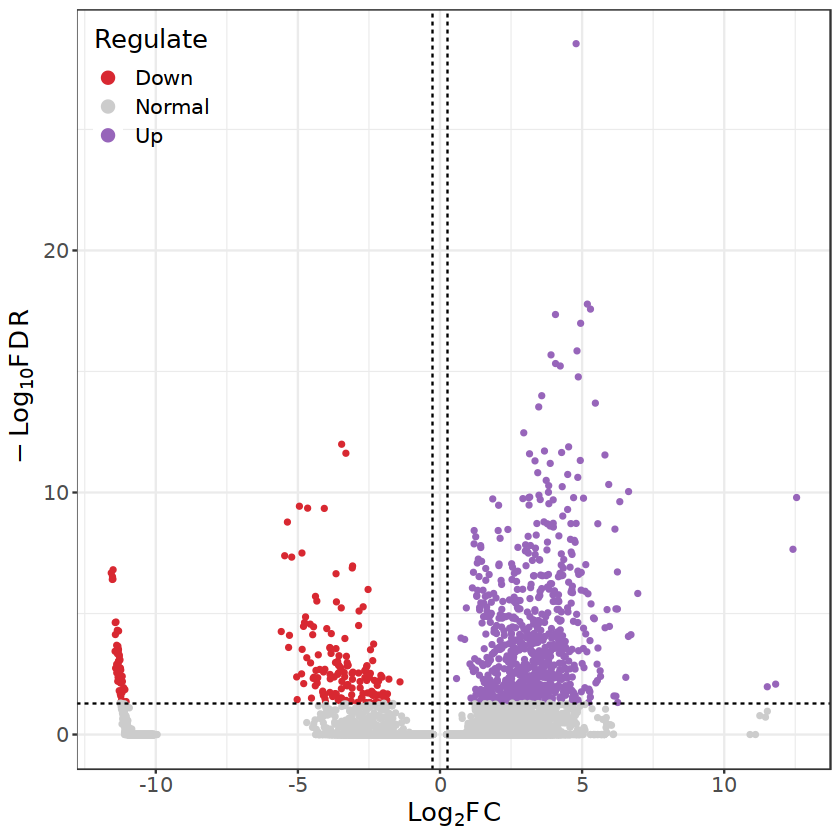

In [37]:
# draw the volcano plot for differentially accessible peaks (pre-HEC vs EC)
da_peaks_prehec_endo <- read.csv("meta/da_peaks_prehec_endo_mouse.csv", row.names = 1)
data <- add_regulate(da_peaks_prehec_endo, log2FC_name = "avg_log2FC", fdr_name = "p_val_adj", log2FC = 0.25, fdr = 0.05)
data$geneName <- rownames(data)
ggvolcano(data, x = "log2FoldChange", y = "padj", label_number = 0, output = FALSE, log2FC_cut = 0.25, fills = c("#D82831", "grey80", "#9765BA"), colors = c("#D82831", "grey80", "#9765BA"))
ggsave("figure/peaks_volcano_prehec_endo_mouse.pdf", width = 6, height = 4.5)

In [38]:
# differentially accessible peaks between pre-HEC and Hema
DefaultAssay(sample) <- 'peaks'
Idents(sample) <- sample$celltype
suppressWarnings({
da_peaks_prehec_hema <- FindMarkers(
  object = sample,
  ident.1 = c("pre-HEC"), 
  ident.2 = c("HEC/HSC"),
  min.pct = 0.05,
  test.use = 'LR',
  latent.vars = 'peak_region_fragments',
  verbose = FALSE)
})
write.csv(da_peaks_prehec_hema, "meta/da_peaks_prehec_hema_mouse.csv")

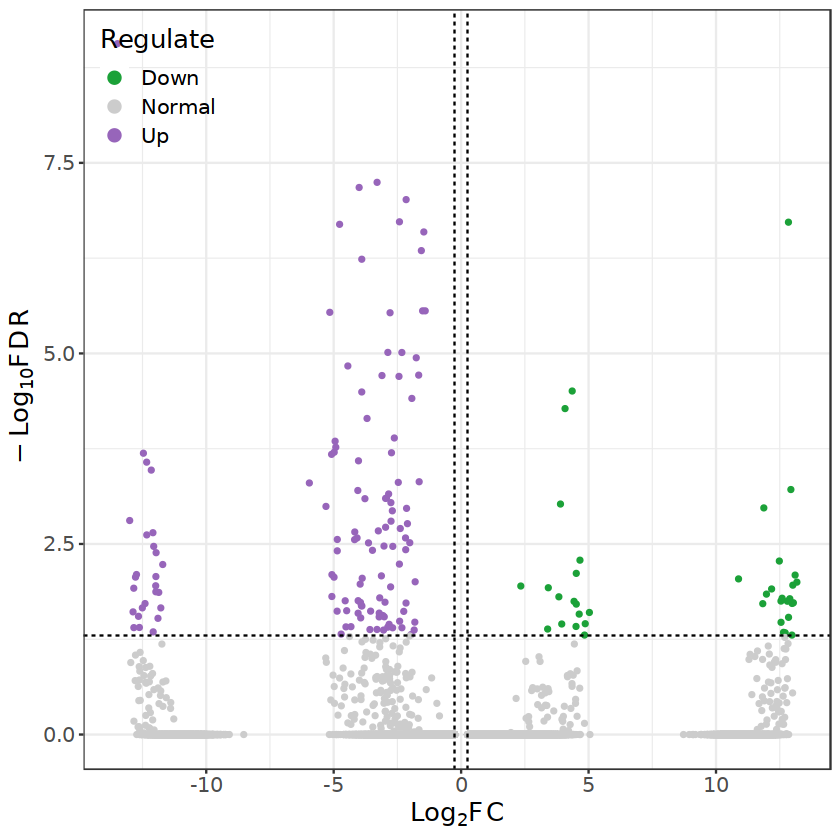

In [39]:
# draw the volcano plot for differentially accessible peaks (pre-HEC vs Hema)
da_peaks_prehec_hema <- read.csv("meta/da_peaks_prehec_hema_mouse.csv", row.names = 1)
data <- add_regulate(da_peaks_prehec_hema, log2FC_name = "avg_log2FC", fdr_name = "p_val_adj", log2FC = 0.25, fdr = 0.05)
data$geneName <- rownames(data)
data$log2FoldChange <- -data$log2FoldChange
ggvolcano(data, x = "log2FoldChange", y = "padj", label_number = 0, output = FALSE, log2FC_cut = 0.25, fills = c("#1BA138", "grey80", "#9765BA"), colors = c("#1BA138", "grey80", "#9765BA"))
ggsave("figure/peaks_volcano_prehec_hema_mouse.pdf", width = 6, height = 4.5)

In [40]:
# filter and annotate the peaks to genes
DefaultAssay(sample) <- 'peaks'
open_peaks_prehec_endo_pos <- rownames(subset(da_peaks_prehec_endo, avg_log2FC >= 0.25 & p_val_adj <= 0.05))
open_peaks_prehec_endo_neg <- rownames(subset(da_peaks_prehec_endo, avg_log2FC <= -0.25 & p_val_adj <= 0.05))
closest_prehec_endo_pos <- ClosestFeature(sample, open_peaks_prehec_endo_pos)
closest_prehec_endo_pos$Positive <- TRUE
closest_prehec_endo_neg <- ClosestFeature(sample, open_peaks_prehec_endo_neg)
closest_prehec_endo_neg$Positive <- FALSE
write.csv(rbind(closest_prehec_endo_pos, closest_prehec_endo_neg), "meta/closest_gene_prehec_endo_mouse.csv")

open_peaks_prehec_hema_pos <- rownames(subset(da_peaks_prehec_hema, avg_log2FC >= 0.25 & p_val_adj <= 0.05))
open_peaks_prehec_hema_neg <- rownames(subset(da_peaks_prehec_hema, avg_log2FC <= -0.25 & p_val_adj <= 0.05))
closest_prehec_hema_pos <- ClosestFeature(sample, open_peaks_prehec_hema_pos)
closest_prehec_hema_pos$Positive <- TRUE
closest_prehec_hema_neg <- ClosestFeature(sample, open_peaks_prehec_hema_neg)
closest_prehec_hema_neg$Positive <- FALSE
write.csv(rbind(closest_prehec_hema_pos, closest_prehec_hema_neg), "meta/closest_gene_prehec_hema_mouse.csv")

Warning message in ClosestFeature(sample, open_peaks_prehec_endo_pos):
“The following seqlevels present in query regions are not present
 in the supplied gene annotations and will be removed: JH584304.1”


In [41]:
# set plotting order
Idents(sample) <- sample$celltype
levels(sample) <- c("VEC","AEC","pre-HEC","HEC/HSC")

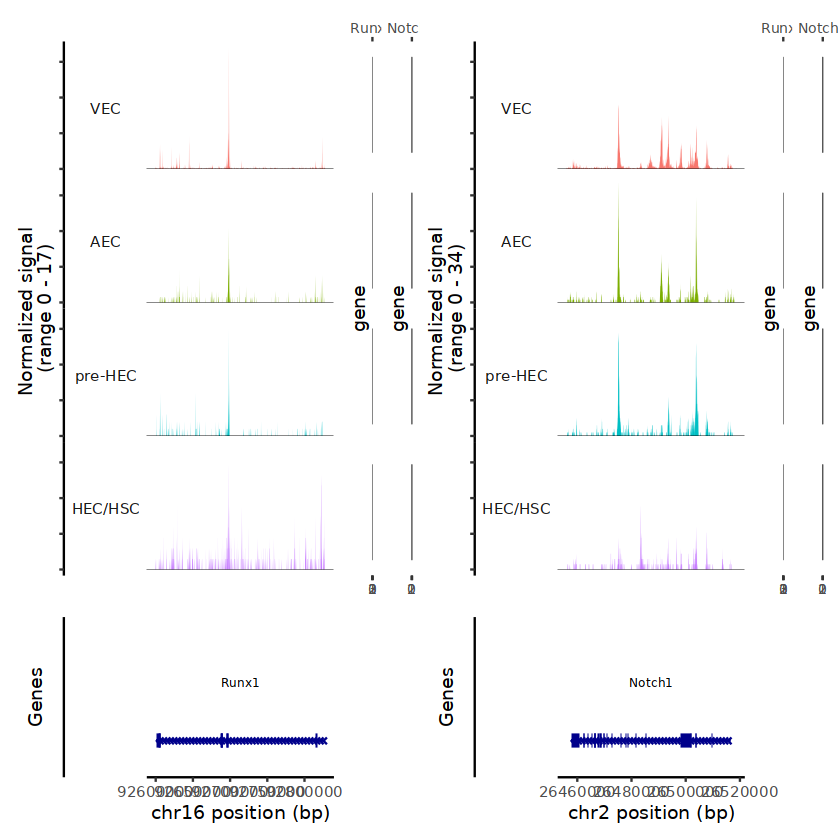

In [42]:
# draw coverage plot
DefaultAssay(sample) <- "peaks"
CoveragePlot(
  object = sample,
  region = c("Runx1", "Notch1"),
  features = c("Runx1", "Notch1"),
  extend.upstream = 2000,
  extend.downstream = 2000,
  peaks = FALSE,
  ncol = 2
)

In [43]:
# load TE GRanges
mm10_te_granges <- readRDS("./meta/mm10_te_granges.rds")

In [44]:
# calculate TE-cell count matrix
# fragments <- Fragments(sample)
# te_count <- FeatureMatrix(fragments = fragments, features = mm10_te_granges, process_n = 20000)
# saveRDS(te_count, file = "TE_cell_count_matrix_raw.rds")
te_count <- readRDS("TE_cell_count_matrix_raw.rds")

In [45]:
# filter extremely low coverage TEs
te_count_filtered <- te_count[which(rowSums(te_count) >= 10), ]
dim(te_count_filtered)

[1] 67496   850

In [46]:
# replace the rownames with interval:TE 
te_mm10 <- read.table("./meta/mm10.te.loc", sep = "\t", header = F, check.names = F)
rownames(te_mm10) <- paste(te_mm10$V1, te_mm10$V2, te_mm10$V3, sep = "-")
rownames(te_count_filtered) <- te_mm10[rownames(te_count_filtered), 'V5']

In [47]:
# create the TE assay
sample[['TE']] <- CreateAssayObject(counts = te_count_filtered)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [48]:
# normalize the TE count data
sample <- NormalizeData(
  object = sample,
  assay = 'TE',
  normalization.method = 'LogNormalize',
  scale.factor = median(sample$nCount_RNA)
)

In [49]:
# find differentially accessible TEs (pre-HEC vs Endo)
DefaultAssay(sample) <- 'TE'
Idents(sample) <- sample$celltype
suppressWarnings({
da_TEs_prehec_endo <- FindMarkers(
  object = sample,
  ident.1 = "pre-HEC",
  ident.2 = c("VEC", "AEC"),
  min.pct = 0.05,
  logfc.threshold = 0,
  test.use = 'LR',
  latent.vars = 'peak_region_fragments')
})

write.csv(da_TEs_prehec_endo, "meta/da_TEs_prehec_endo_mouse.csv")

In [50]:
# filter significant da_TEs (pre-HEC vs Endo)
da_TEs_prehec_endo <- read.csv("meta/da_TEs_prehec_endo_mouse.csv", row.names = 1)
da_TEs_prehec_endo_significant <- subset(da_TEs_prehec_endo, abs(avg_log2FC) >= 0.25 & p_val_adj <= 0.05)
da_TEs_prehec_endo_significant <- da_TEs_prehec_endo_significant[order(da_TEs_prehec_endo_significant$avg_log2FC), ]

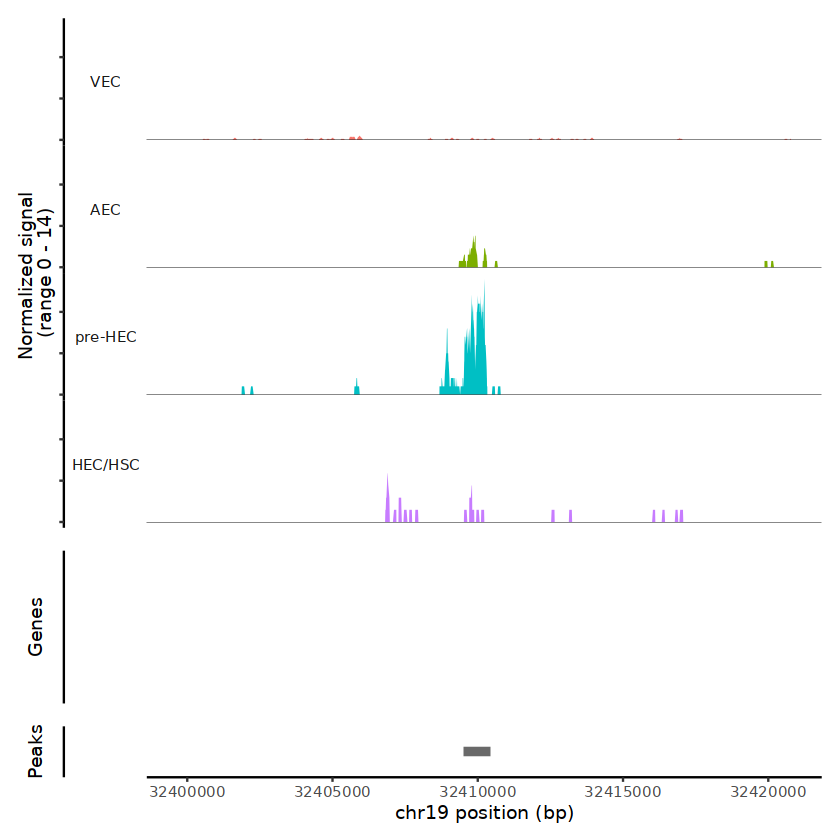

In [51]:
# draw coverage plot
DefaultAssay(sample) <- "peaks"
CoveragePlot(
  object = sample,
  region = c("chr19-32409664-32410784"),
  #features = "Hsp90aa1",
  extend.upstream = 10000,
  extend.downstream = 10000,
  ncol = 1
)

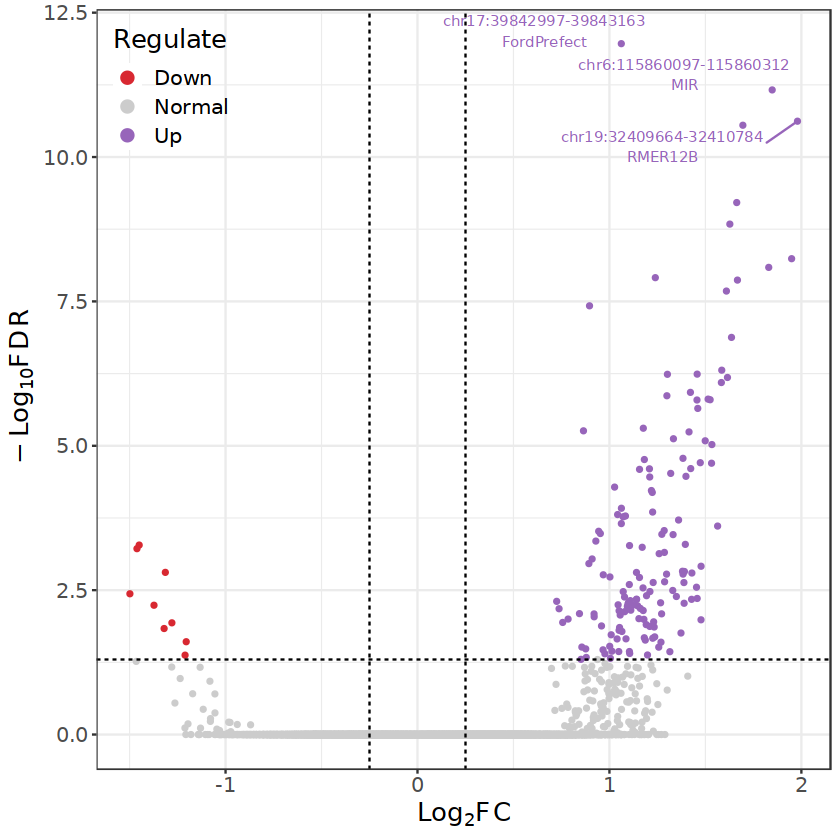

In [52]:
# draw the volcano plot (pre-HEC vs VEC)
data <- add_regulate(da_TEs_prehec_endo, log2FC_name = "avg_log2FC", fdr_name = "p_val_adj", log2FC = 0.25, fdr = 0.05)
data$TE <- unlist(strsplit(rownames(data), split = ":|\\."))[seq(3, nrow(data) * 5, by = 5)]
data$Superfamily <- unlist(strsplit(rownames(data), split = ":|\\."))[seq(4, nrow(data) * 5, by = 5)]
data$Class <- unlist(strsplit(rownames(data), split = ":|\\."))[seq(5, nrow(data) * 5, by = 5)]
data$interval <- paste(unlist(strsplit(rownames(data), split = ":"))[seq(1, nrow(data) * 3, by = 3)], unlist(strsplit(rownames(data), split = ":"))[seq(2, nrow(data) * 3, by = 3)], sep = ":")
data$TE_interval <- paste(data$interval, data$TE, sep = "\n")

ggvolcano(data, x = "log2FoldChange", y = "padj", label = "TE_interval", label_number = 3, output = FALSE, log2FC_cut = 0.25, fills = c("#D82831", "grey80", "#9765BA"), colors = c("#D82831", "grey80", "#9765BA"))
ggsave("figure/TEs_volcano_prehec_endo_mouse.pdf", width = 4, height = 3)

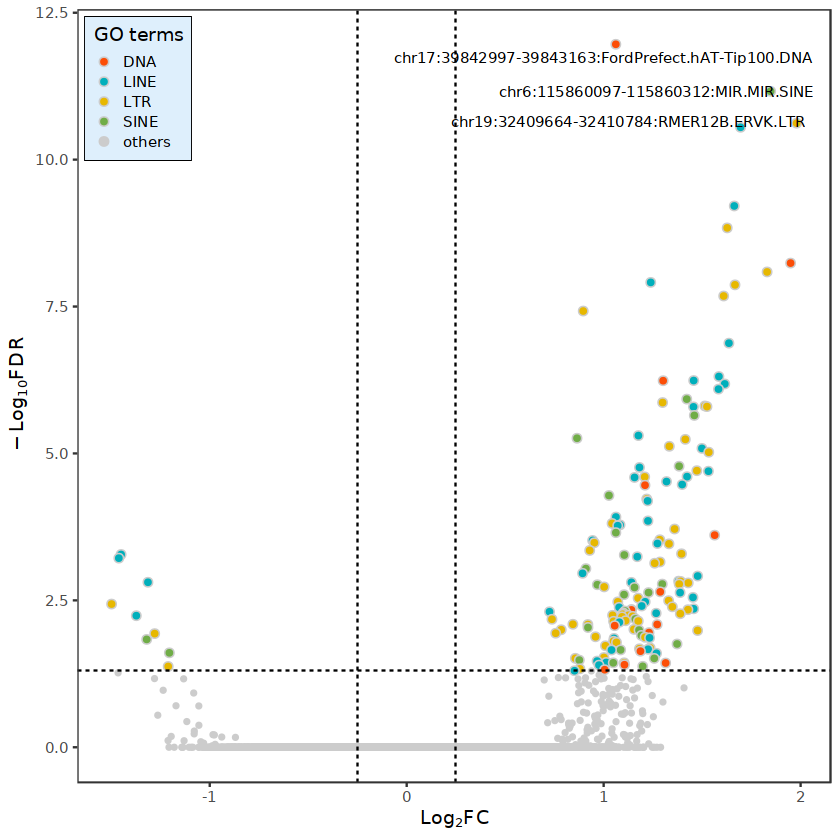

In [53]:
# draw the volcano plot with TE class (pre-HEC vs VEC)
data$row <- rownames(data)
te_class_data <- data[which(abs(data$log2FoldChange) >= 0.25 & data$padj <= 0.05), ]
te_class_data <- data.frame(Gene.names = rownames(te_class_data), term = te_class_data$Class)
term_volcano(data, te_class_data,
             x = "log2FoldChange", y = "padj",
             normal_point_color = "grey80",
             deg_point_fill = c("#FC4E07", "#00AFBB", "#E7B800", "#70AD47", "grey80"),
             deg_point_color = "grey80",
             legend_background_fill = "#deeffc",
             label = "row", label_number = 3, log2FC_cut = 0.25, output = FALSE)

In [54]:
# find differentially accessible TEs (pre-HEC vs Hema)
DefaultAssay(sample) <- 'TE'
Idents(sample) <- sample$celltype
suppressWarnings({
da_TEs_prehec_hema <- FindMarkers(
  object = sample,
  ident.1 = "pre-HEC",
  ident.2 = "HEC/HSC",
  min.pct = 0.05,
  logfc.threshold = 0,
  test.use = 'LR',
  latent.vars = 'peak_region_fragments')
})

write.csv(da_TEs_prehec_hema, "meta/da_TEs_prehec_hema_mouse.csv")

In [55]:
# filter significant da_TEs (HSC vs pre-HEC)
da_TEs_prehec_hema <- read.csv("meta/da_TEs_prehec_hema_mouse.csv", row.names = 1)
da_TEs_prehec_hema_significant <- subset(da_TEs_prehec_hema, abs(avg_log2FC) >= 0.25 & p_val_adj <= 0.05)
da_TEs_prehec_hema_significant <- da_TEs_prehec_hema_significant[order(da_TEs_prehec_hema_significant$avg_log2FC), ]

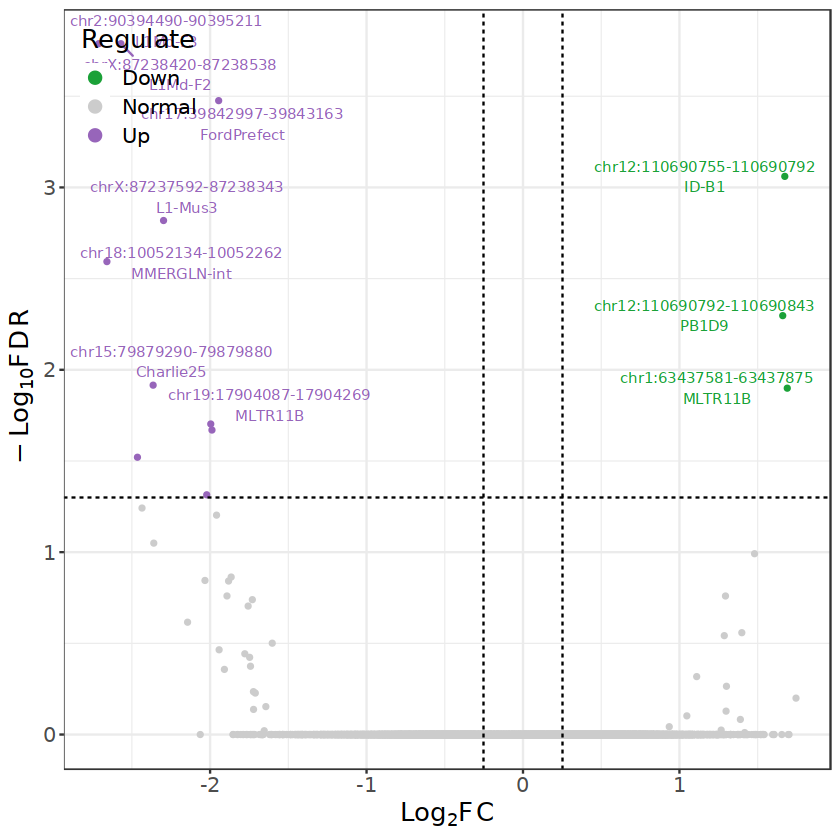

In [56]:
# draw the volcano plot (pre-HEC vs Hema)
data <- add_regulate(da_TEs_prehec_hema, log2FC_name = "avg_log2FC", fdr_name = "p_val_adj", log2FC = 0.25, fdr = 0.05)
data$TE <- unlist(strsplit(rownames(data), split = ":|\\."))[seq(3, nrow(data) * 5, by = 5)]
data$interval <- paste(unlist(strsplit(rownames(data), split = ":"))[seq(1, nrow(data) * 3, by = 3)], unlist(strsplit(rownames(data), split = ":"))[seq(2, nrow(data) * 3, by = 3)], sep = ":")
data$TE_interval <- paste(data$interval, data$TE, sep = "\n")
data$log2FoldChange <- -data$log2FoldChange
ggvolcano(data, x = "log2FoldChange", y = "padj", label = "TE_interval", label_number = 10, output = FALSE, log2FC_cut = 0.25, fills = c("#1BA138", "grey80", "#9765BA"), colors = c("#1BA138", "grey80", "#9765BA"))
ggsave("figure/TEs_volcano_prehec_hema_mouse.pdf", width = 4, height = 3)

In [57]:
# find all differentially accessible TEs
DefaultAssay(sample) <- 'TE'
Idents(sample) <- sample$celltype
suppressWarnings({
da_TEs_all <- FindAllMarkers(
  object = sample,
  min.pct = 0.05,
  only.pos = T,
  test.use = 'LR',
  latent.vars = 'peak_region_fragments')
})

write.csv(da_TEs_all, "meta/da_TEs_all_mouse.csv")

Calculating cluster VEC

Calculating cluster AEC

Calculating cluster pre-HEC

Calculating cluster HEC/HSC




    AEC HEC/HSC     VEC pre-HEC 
     43     109     133     140 

Warning message:
“Scaling data with a low number of groups may produce misleading results”


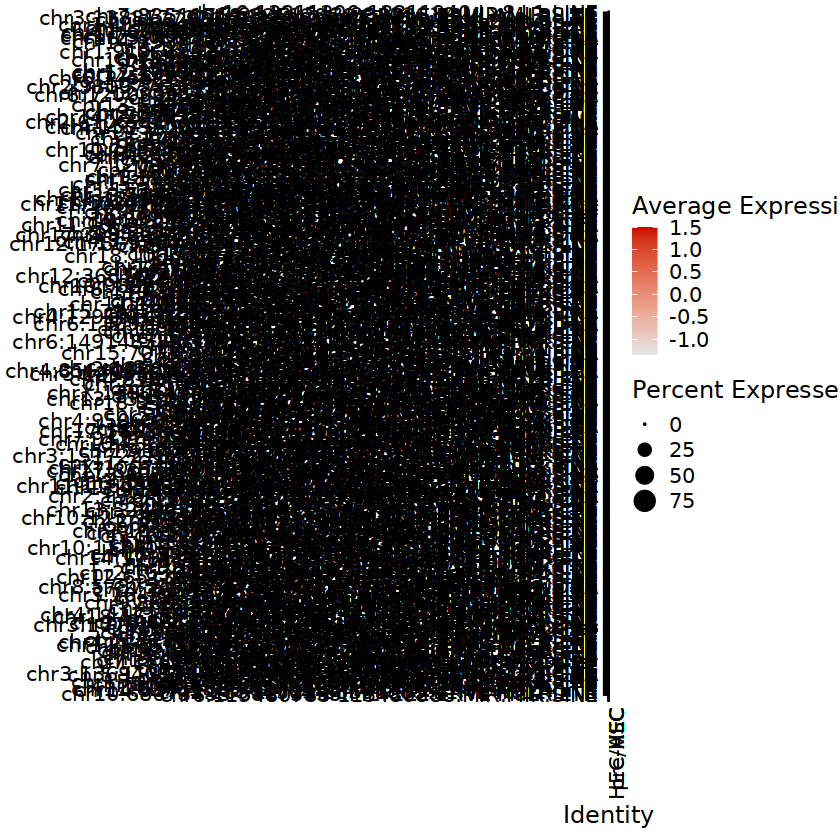

In [58]:
# plot most significant TE
# da_TEs_significant <- unique(c(rownames(da_TEs_prehec_endo_significant), rownames(da_TEs_prehec_hema_significant)))
da_TEs_all <- read.csv("meta/da_TEs_all_mouse.csv", row.names = 1)
da_TEs_significant <- subset(da_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5)
table(da_TEs_significant$cluster)
da_TEs_significant <- unique(da_TEs_significant$gene)
DefaultAssay(sample) <- "TE"
DotPlot(sample, features = rev(da_TEs_significant), cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
#ggsave("figure/dotplot_da_TEs_significant.pdf", width = 10, height = 60, limitsize = F)

Centering and scaling data matrix

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


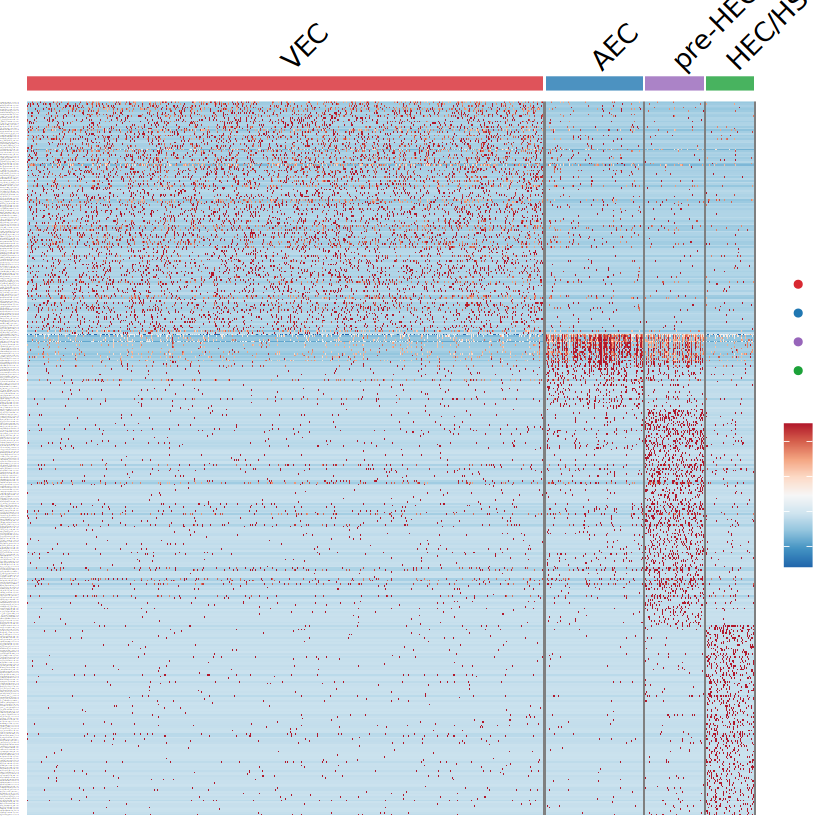

In [59]:
# plot significant TEs heatmap
sample <- ScaleData(sample, assay = "TE", features = da_TEs_significant)
mapal <- rev(colorRampPalette(RColorBrewer::brewer.pal(9, "RdBu"))(100))
DoHeatmap(sample, features = da_TEs_significant, assay = "TE", raster = T, group.colors = alpha(c("#D82831", "#2077B2", "#9765BA", "#1BA138"), 0.8)) + theme(text = element_text(size = 0, color = "white")) + scale_fill_gradientn(colours = mapal)
# DoHeatmap(sample, features = da_TEs_significant, assay = "TE", disp.min = 0) + theme(text = element_text(size = 0)) + scale_fill_viridis()
ggsave("figure/heatmap_da_TEs_significant.pdf", width = 3, height = 3)

In [60]:
# annotate the TEs to genes
DefaultAssay(sample) <- "peaks"

open_TEs_vec <- subset(da_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "VEC")$gene
open_TEs_vec_loc <- unlist(lapply(open_TEs_vec, function(TE_name){
    TE_name_chr <- unlist(strsplit(TE_name, split = ":"))[1]
    TE_name_pos <- unlist(strsplit(TE_name, split = ":"))[2]
    paste(TE_name_chr, TE_name_pos, sep = "-")
}))
closest_genes_vec <- ClosestFeature(sample, open_TEs_vec_loc)

open_TEs_aec <- subset(da_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "AEC")$gene
open_TEs_aec_loc <- unlist(lapply(open_TEs_aec, function(TE_name){
    TE_name_chr <- unlist(strsplit(TE_name, split = ":"))[1]
    TE_name_pos <- unlist(strsplit(TE_name, split = ":"))[2]
    paste(TE_name_chr, TE_name_pos, sep = "-")
}))
closest_genes_aec <- ClosestFeature(sample, open_TEs_aec_loc)

open_TEs_prehec <- subset(da_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "pre-HEC")$gene
open_TEs_prehec_loc <- unlist(lapply(open_TEs_prehec, function(TE_name){
    TE_name_chr <- unlist(strsplit(TE_name, split = ":"))[1]
    TE_name_pos <- unlist(strsplit(TE_name, split = ":"))[2]
    paste(TE_name_chr, TE_name_pos, sep = "-")
}))
closest_genes_prehec <- ClosestFeature(sample, open_TEs_prehec_loc)

open_TEs_hsc <- subset(da_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "HEC/HSC")$gene
open_TEs_hsc_loc <- unlist(lapply(open_TEs_hsc, function(TE_name){
    TE_name_chr <- unlist(strsplit(TE_name, split = ":"))[1]
    TE_name_pos <- unlist(strsplit(TE_name, split = ":"))[2]
    paste(TE_name_chr, TE_name_pos, sep = "-")
}))
closest_genes_hsc <- ClosestFeature(sample, open_TEs_hsc_loc)

In [61]:
# save the data
saveRDS(sample, file = "sample_mouse_ATAC_TE.rds")

In [62]:
# generate open TE class table
te_class_vec <- as.data.frame(table(unlist(strsplit(open_TEs_vec, split = "\\."))[seq(3, 3 * length(open_TEs_vec), by = 3)]))
te_class_vec$Var1 <- as.character(te_class_vec$Var1)
te_class_vec <- te_class_vec[-which(te_class_vec$Var1 == "Other"), ]
rownames(te_class_vec) <- te_class_vec$Var1
te_class_vec <- as.data.frame(t(te_class_vec))
te_class_vec <- te_class_vec[-1, ]
rownames(te_class_vec) <- "VECs"
te_class_vec <- mutate_all(te_class_vec, function(x) as.numeric(as.character(x)))
#te_class_vec <- (te_class_vec - min(te_class_vec)) / (max(te_class_vec) - min(te_class_vec))
te_class_vec <- te_class_vec %>% as_tibble(rownames = "group")

te_class_aec <- as.data.frame(table(unlist(strsplit(open_TEs_aec, split = "\\."))[seq(3, 3 * length(open_TEs_aec), by = 3)]))
rownames(te_class_aec) <- te_class_aec$Var1
te_class_aec <- as.data.frame(t(te_class_aec))
te_class_aec <- te_class_aec[-1, ]
rownames(te_class_aec) <- "AECs"
te_class_aec <- mutate_all(te_class_aec, function(x) as.numeric(as.character(x)))
#te_class_aec <- (te_class_aec - min(te_class_aec)) / (max(te_class_aec) - min(te_class_aec))
te_class_aec <- te_class_aec %>% as_tibble(rownames = "group")

te_class_prehec <- as.data.frame(table(unlist(strsplit(open_TEs_prehec, split = "\\."))[seq(3, 3 * length(open_TEs_prehec), by = 3)]))
rownames(te_class_prehec) <- te_class_prehec$Var1
te_class_prehec <- as.data.frame(t(te_class_prehec))
te_class_prehec <- te_class_prehec[-1, ]
rownames(te_class_prehec) <- "pre-HECs"
te_class_prehec <- mutate_all(te_class_prehec, function(x) as.numeric(as.character(x)))
#te_class_prehec <- (te_class_prehec - min(te_class_prehec)) / (max(te_class_prehec) - min(te_class_prehec))
te_class_prehec <- te_class_prehec %>% as_tibble(rownames = "group")

te_class_hsc <- as.data.frame(table(unlist(strsplit(open_TEs_hsc, split = "\\."))[seq(3, 3 * length(open_TEs_hsc), by = 3)]))
te_class_hsc$Var1 <- as.character(te_class_hsc$Var1)
te_class_hsc <- te_class_hsc[-which(te_class_hsc$Var1 == "Other"), ]
rownames(te_class_hsc) <- te_class_hsc$Var1
te_class_hsc <- as.data.frame(t(te_class_hsc))
te_class_hsc <- te_class_hsc[-1, ]
rownames(te_class_hsc) <- "HECs/HSCs"
te_class_hsc <- mutate_all(te_class_hsc, function(x) as.numeric(as.character(x)))
#te_class_hsc <- (te_class_hsc - min(te_class_hsc)) / (max(te_class_hsc) - min(te_class_hsc))
te_class_hsc <- te_class_hsc %>% as_tibble(rownames = "group")

te_class_all <- rbind(te_class_vec, te_class_aec, te_class_prehec, te_class_hsc)
te_class_all$group <- factor(te_class_all$group, levels = c("VECs","AECs","pre-HECs","HECs/HSCs"))
te_class_all

group     DNA LINE LTR SINE
1 VECs      14  26   55  37  
2 AECs       3  15   15  10  
3 pre-HECs  13  45   57  25  
4 HECs/HSCs  4  21   49  33

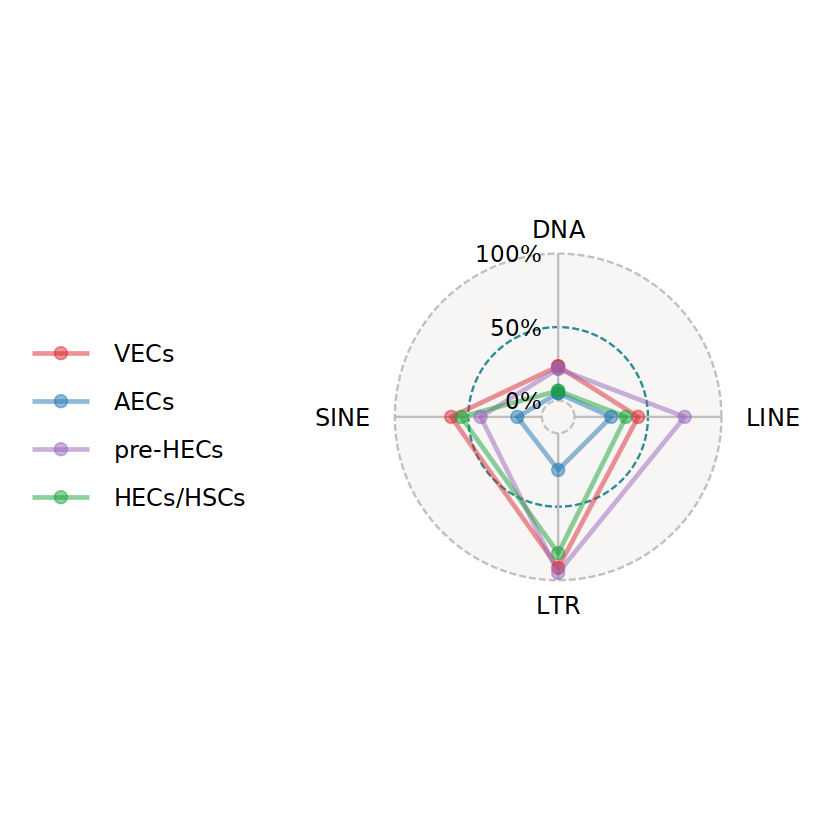

In [63]:
# plot open TE class
ggradar(te_class_all, grid.max = 60, grid.mid = 30, grid.min = 0, group.colours = alpha(c("#D82831", "#2077B2", "#9765BA", "#1BA138"), 0.5), group.point.size = 3, group.line.width = 1)
ggsave("figure/open_TEs_class_mouse.pdf", width = 5, height = 3)

In [64]:
# output TEs to bed file
DefaultAssay(sample) <- "peaks"

open_TEs_vec <- subset(da_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "VEC")
open_TEs_vec <- open_TEs_vec[order(open_TEs_vec$gene), ]

open_TEs_vec_loc <- unlist(lapply(open_TEs_vec$gene, function(TE_name){
    TE_name_chr <- unlist(strsplit(TE_name, split = ":|-|\\."))[1]
    TE_name_start <- unlist(strsplit(TE_name, split = ":|-|\\."))[2]
    TE_name_end <- unlist(strsplit(TE_name, split = ":|-|\\."))[3]
    TE_name_family <- unlist(strsplit(TE_name, split = ":|-|\\."))[4]
    TE_name_superfamily <- unlist(strsplit(TE_name, split = ":|-|\\."))[5]
    TE_name_class <- unlist(strsplit(TE_name, split = ":|-|\\."))[6]
    paste(TE_name_chr, TE_name_start, TE_name_end, TE_name_family, TE_name_superfamily, TE_name_class, "VEC", sep = "\t")
}))
write.table(open_TEs_vec_loc, "./meta/crp/open_TEs_vec_loc_mouse.bed", sep = "\t", row.names = F, col.names = F, quote = F)

open_TEs_aec <- subset(da_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "AEC")
open_TEs_aec <- open_TEs_aec[order(open_TEs_aec$gene), ]

open_TEs_aec_loc <- unlist(lapply(open_TEs_aec$gene, function(TE_name){
    TE_name_chr <- unlist(strsplit(TE_name, split = ":|-|\\."))[1]
    TE_name_start <- unlist(strsplit(TE_name, split = ":|-|\\."))[2]
    TE_name_end <- unlist(strsplit(TE_name, split = ":|-|\\."))[3]
    TE_name_family <- unlist(strsplit(TE_name, split = ":|-|\\."))[4]
    TE_name_superfamily <- unlist(strsplit(TE_name, split = ":|-|\\."))[5]
    TE_name_class <- unlist(strsplit(TE_name, split = ":|-|\\."))[6]
    paste(TE_name_chr, TE_name_start, TE_name_end, TE_name_family, TE_name_superfamily, TE_name_class, "AEC", sep = "\t")
}))
write.table(open_TEs_aec_loc, "./meta/crp/open_TEs_aec_loc_mouse.bed", sep = "\t", row.names = F, col.names = F, quote = F)

open_TEs_prehec <- subset(da_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "pre-HEC")
open_TEs_prehec <- open_TEs_prehec[order(open_TEs_prehec$gene), ]

open_TEs_prehec_loc <- unlist(lapply(open_TEs_prehec$gene, function(TE_name){
    TE_name_chr <- unlist(strsplit(TE_name, split = ":|-|\\."))[1]
    TE_name_start <- unlist(strsplit(TE_name, split = ":|-|\\."))[2]
    TE_name_end <- unlist(strsplit(TE_name, split = ":|-|\\."))[3]
    TE_name_family <- unlist(strsplit(TE_name, split = ":|-|\\."))[4]
    TE_name_superfamily <- unlist(strsplit(TE_name, split = ":|-|\\."))[5]
    TE_name_class <- unlist(strsplit(TE_name, split = ":|-|\\."))[6]
    paste(TE_name_chr, TE_name_start, TE_name_end, TE_name_family, TE_name_superfamily, TE_name_class, "pre-HEC", sep = "\t")
}))
write.table(open_TEs_prehec_loc, "./meta/crp/open_TEs_prehec_loc_mouse.bed", sep = "\t", row.names = F, col.names = F, quote = F)

open_TEs_hsc <- subset(da_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "HEC/HSC")
open_TEs_hsc <- open_TEs_hsc[order(open_TEs_hsc$gene), ]

open_TEs_hsc_loc <- unlist(lapply(open_TEs_hsc$gene, function(TE_name){
    TE_name_chr <- unlist(strsplit(TE_name, split = ":|-|\\."))[1]
    TE_name_start <- unlist(strsplit(TE_name, split = ":|-|\\."))[2]
    TE_name_end <- unlist(strsplit(TE_name, split = ":|-|\\."))[3]
    TE_name_family <- unlist(strsplit(TE_name, split = ":|-|\\."))[4]
    TE_name_superfamily <- unlist(strsplit(TE_name, split = ":|-|\\."))[5]
    TE_name_class <- unlist(strsplit(TE_name, split = ":|-|\\."))[6]
    paste(TE_name_chr, TE_name_start, TE_name_end, TE_name_family, TE_name_superfamily, TE_name_class, "HEC/HSC", sep = "\t")
}))
write.table(open_TEs_hsc_loc, "./meta/crp/open_TEs_hsc_loc_mouse.bed", sep = "\t", row.names = F, col.names = F, quote = F)

group   PLS pELS dELS CTCF DNase
1 VEC     0   5    40   2    0    
2 AEC     0   1     1   3    1    
3 preHEC  0   3    30   3    0    
4 HEC_HSC 0   6    62   2    0

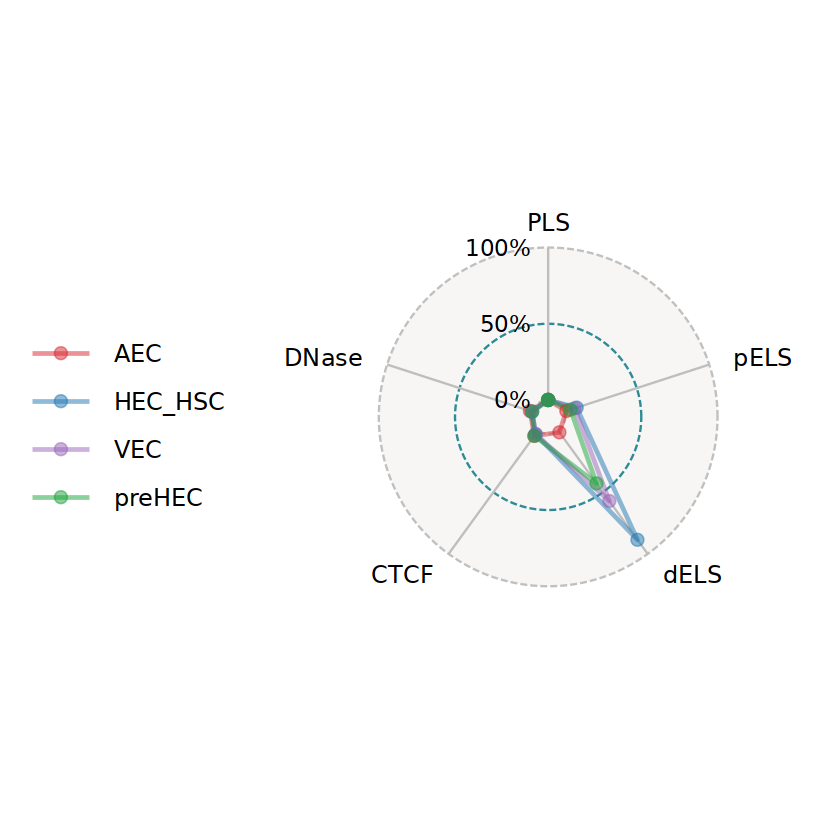

In [65]:
# plot open TE type (PLS, pELS, dELS, CTCF, DNase)
te_crp_all <- data.frame(row.names = c("PLS","pELS","dELS","CTCF","DNase"), VEC = c(0,5,40,2,0), AEC = c(0,1,1,3,1), preHEC = c(0,3,30,3,0), HEC_HSC = c(0,6,62,2,0))
te_crp_all <- t(te_crp_all)
te_crp_all <- te_crp_all %>% as_tibble(rownames = "group")
te_crp_all
ggradar(te_crp_all, grid.max = 70, grid.mid = 35, grid.min = 0, group.colours = alpha(c("#D82831", "#2077B2", "#9765BA", "#1BA138"), 0.5), group.point.size = 3, group.line.width = 1)
ggsave("figure/open_TEs_crp_mouse.pdf", width = 5, height = 3)

In [66]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.1.2     scales_1.2.1        ggradar_0.2        
 [4] viridis_0.6.2       viridisLite_0.4.1   ggVolcano_0.0.2    
 [7] lubridate_1.9.2     forcats_1.0.0       dplyr_1.1.1        
[10] purrr_1.0.1         readr_2.1.4         tidyr_1.3.0        
[13] tibble_3.2.0        tidyverse_2.0.0     ggpubr_0.6.0       
[16] ggplot2_3.4.2       stringr_1.5.0       AnnotationHub_3.6.0
[19] BiocFile